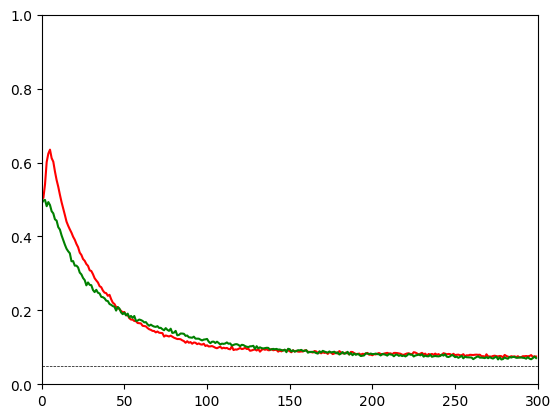

In [101]:
import numpy as np
import matplotlib.pyplot as plt

class SimpleEnv:
    def __init__(self) -> None:
        self.state = 0

    def state_shape(self):
        return (2,)
    
    def action_shape(self):
        return 2
    
    def reset(self):
        self.state = 0
        return 0

    def step(self, action):
        assert(action == 0 or action == 1)
        if self.state == 0:
            if action == 0:
                return True, 0, 0
            else:
                self.state = 1
                return False, 1, 0
        else:
            return True, 0, np.random.normal(-0.1, 1.0)


def epsilon_greed(qs, epsilon):
    if np.random.random() < epsilon:
        return np.random.choice(len(qs))
    else:
        ismaxs = qs.max() == qs
        indices = [i for i in range(len(qs)) if ismaxs[i]]
        return np.random.choice(indices)#slow
        #return qs.argmax()

def q_learning(env, num_episodes, alpha, epsilon = 0.1, gamma = 1.0):
    state_shape = env.state_shape()
    action_shape = env.action_shape()
    q_shape = state_shape + (action_shape,)
    qs = np.zeros(q_shape)
    counts_0 = []
    for episode in range(num_episodes):
        count_0_0 = 0
        count_0_1 = 0
        state = env.reset()
        while True:
            action = epsilon_greed(qs[state], epsilon)
            if 0 == state:
                if 0 == action:
                    count_0_0 += 1
                else:
                    count_0_1 += 1
            terminated, next_state, reward = env.step(action)
            q_prime = 0 if terminated else qs[next_state].max()
            qs[state][action] += (reward + q_prime * gamma - qs[state][action]) * alpha
            if terminated:
                break
            state = next_state
        counts_0.append((count_0_0,count_0_1))
    return counts_0

def double_q_learning(env, num_episodes, alpha, epsilon = 0.1, gamma = 1.0):
    state_shape = env.state_shape()
    action_shape = env.action_shape()
    q_shape = state_shape + (action_shape,)
    qs_a = np.zeros(q_shape)
    qs_b = np.zeros(q_shape)
    counts_0 = []
    for episode in range(num_episodes):
        count_0_0 = 0
        count_0_1 = 0
        state = env.reset()
        while True:
            qs1, qs2 = (qs_a, qs_b) if np.random.random() < 0.5 else (qs_b, qs_a)
            action = epsilon_greed(qs1[state], epsilon)
            if 0 == state:
                if 0 == action:
                    count_0_0 += 1
                else:
                    count_0_1 += 1
            terminated, next_state, reward = env.step(action)
            if terminated:
                q_prime = 0
            else:
                next_action = epsilon_greed(qs1[next_state], epsilon)
                q_prime = qs2[next_state][next_action]
            qs1[state][action] += (reward + q_prime * gamma - qs1[state][action]) * alpha
            if terminated:
                break
            state = next_state
        counts_0.append((count_0_0,count_0_1))
    return counts_0

env = SimpleEnv()

num_episodes = 300
avg_counts = np.zeros((num_episodes, 2))
dq_avg_counts = np.zeros((num_episodes, 2))

for n in range(10000):
    counts_0 = q_learning(env, num_episodes, 0.1)
    avg_counts += counts_0
    counts_0 = double_q_learning(env, num_episodes, 0.1)
    dq_avg_counts += counts_0

q_probs = np.zeros(num_episodes)
q_probs[:] = avg_counts[:,1]/avg_counts.sum(1)

dq_probs = np.zeros(num_episodes)
dq_probs[:] = dq_avg_counts[:,1]/dq_avg_counts.sum(1)


plt.ylim((0,1))
plt.xlim((0,num_episodes))
plt.axhline(y=0.05, c='k', ls='--', lw=0.5)
plt.plot(range(num_episodes),q_probs,"r")
plt.plot(range(num_episodes),dq_probs,"g")
